## **Time Travel Using Persistence**

In [1]:
import sqlite3
from typing import TypedDict
from langgraph.graph import StateGraph, START, END
from langgraph.types import interrupt
from langchain_ollama import ChatOllama
from langchain_core.messages import SystemMessage, HumanMessage
from langchain_community.tools import DuckDuckGoSearchRun
from langgraph.checkpoint.sqlite import SqliteSaver


In [2]:
# ===================== MODEL =====================
model = ChatOllama(
    model="qwen2.5:0.5b",
    temperature=0.3
)


In [3]:
# ===================== STATE =====================
class JokeState(TypedDict):
    topic: str
    joke: str
    explanation: str


In [4]:
# ===================== TOOLS =====================
search_tool = DuckDuckGoSearchRun(name="Search")


In [5]:
# ===================== NODES =====================
def generate_joke(state: JokeState):
    prompt = f"Generate a joke on the topic: {state['topic']}"
    response = model.invoke(prompt).content
    return {'joke': response}

def generate_explanation(state: JokeState):
    prompt = f"Write an explanation for the joke: {state['joke']}"
    response = model.invoke(prompt).content
    return {'explanation': response}


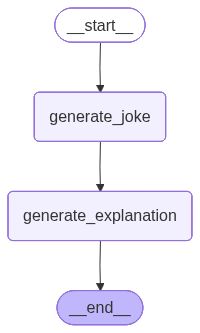

In [6]:
# ===================== GRAPH =====================
graph = StateGraph(JokeState)

# Node
graph.add_node('generate_joke', generate_joke)
graph.add_node('generate_explanation', generate_explanation)

# Edge
graph.add_edge(START, 'generate_joke')
graph.add_edge('generate_joke', 'generate_explanation')
graph.add_edge('generate_explanation', END)

# ===================== CHECKPOINTER =====================
conn = sqlite3.connect("Joke.db", check_same_thread=False)
checkpointer = SqliteSaver(conn)

workflow = graph.compile(checkpointer=checkpointer)

workflow

In [7]:
config1 = {"configurable": {"thread_id": "1"}}
initial_state = {'topic': 'pizza'}
response = workflow.invoke(initial_state, config=config1)
print(response)


{'topic': 'pizza', 'joke': 'Why did the tomato go to the doctor? Because it had a problem with its sauce!', 'explanation': 'The joke is a play on words and a clever way of making a point about how we often make assumptions without realizing they\'re not accurate or helpful. In this case, the punchline is that the tomato went to the doctor because it had a problem with its sauce.\nTo break it down:\n1. The tomato is a fruit and doesn\'t have any problems with sauces.\n2. When someone says "Tomato went to the doctor, because it had a problem with its sauce! ", they are implying that the tomato has some kind of problem or issue related to its sauce.\n3. This play on words is meant to be humorous, as the joke is about how we often make assumptions without realizing they\'re not accurate or helpful.\n4. The punchline serves to point out a common mistake in our thinking - that tomatoes are always good for sauces and should never have any issues with sauces at all!\nOverall, the joke is a cle

In [8]:
workflow.get_state(config=config1)

StateSnapshot(values={'topic': 'pizza', 'joke': 'Why did the tomato go to the doctor? Because it had a problem with its sauce!', 'explanation': 'The joke is a play on words and a clever way of making a point about how we often make assumptions without realizing they\'re not accurate or helpful. In this case, the punchline is that the tomato went to the doctor because it had a problem with its sauce.\nTo break it down:\n1. The tomato is a fruit and doesn\'t have any problems with sauces.\n2. When someone says "Tomato went to the doctor, because it had a problem with its sauce! ", they are implying that the tomato has some kind of problem or issue related to its sauce.\n3. This play on words is meant to be humorous, as the joke is about how we often make assumptions without realizing they\'re not accurate or helpful.\n4. The punchline serves to point out a common mistake in our thinking - that tomatoes are always good for sauces and should never have any issues with sauces at all!\nOvera

In [9]:
list(workflow.get_state_history(config=config1))

[StateSnapshot(values={'topic': 'pizza', 'joke': 'Why did the tomato go to the doctor? Because it had a problem with its sauce!', 'explanation': 'The joke is a play on words and a clever way of making a point about how we often make assumptions without realizing they\'re not accurate or helpful. In this case, the punchline is that the tomato went to the doctor because it had a problem with its sauce.\nTo break it down:\n1. The tomato is a fruit and doesn\'t have any problems with sauces.\n2. When someone says "Tomato went to the doctor, because it had a problem with its sauce! ", they are implying that the tomato has some kind of problem or issue related to its sauce.\n3. This play on words is meant to be humorous, as the joke is about how we often make assumptions without realizing they\'re not accurate or helpful.\n4. The punchline serves to point out a common mistake in our thinking - that tomatoes are always good for sauces and should never have any issues with sauces at all!\nOver

In [10]:
# [
#     StateSnapshot(values={'topic': 'pizza', 'joke': 'Why did the pizza go to the doctor?\n\nBecause it had an ulcer!', 'explanation': 'The joke plays on the common misconception that all ulcers are caused by eating spicy foods or smoking cigarettes. However, in reality, many people with ulcers actually don\'t eat much food and instead consume a diet rich in vegetables, fruits, and whole grains.\n\nIn this case, the pizza is not an ulcer but rather a healthy and balanced meal that provides the body with all the necessary nutrients it needs to heal its wounds. The joke is meant to highlight the importance of eating a balanced diet and avoiding foods that can exacerbate ulcers or other digestive issues.\n\nThe punchline of the joke is that the pizza was "doctored" by the doctor, as he prescribed it with a variety of healthy ingredients to help treat the ulcer. This shows us that sometimes, we need to be creative in our approach when dealing with health-related problems and try out new foods or dietary changes.'}, next=(), config={'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1f0ed92e-937c-696b-8002-32c54448c960'}}, metadata={'source': 'loop', 'step': 2, 'parents': {}}, created_at='2026-01-09T19:39:28.224087+00:00', parent_config={'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1f0ed92e-7888-602a-8001-c297dd735ba5'}}, tasks=(), interrupts=()),
#     StateSnapshot(values={'topic': 'pizza', 'joke': 'Why did the pizza go to the doctor?\n\nBecause it had an ulcer!'}, next=('generate_explanation',), config={'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1f0ed92e-7888-602a-8001-c297dd735ba5'}}, metadata={'source': 'loop', 'step': 1, 'parents': {}}, created_at='2026-01-09T19:39:25.397610+00:00', parent_config={'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1f0ed92e-67bf-6a10-8000-f7e6bb271474'}}, tasks=(PregelTask(id='65022160-b5dd-3649-0485-1df159d03b2e', name='generate_explanation', path=('__pregel_pull', 'generate_explanation'), error=None, interrupts=(), state=None, result={'explanation': 'The joke plays on the common misconception that all ulcers are caused by eating spicy foods or smoking cigarettes. However, in reality, many people with ulcers actually don\'t eat much food and instead consume a diet rich in vegetables, fruits, and whole grains.\n\nIn this case, the pizza is not an ulcer but rather a healthy and balanced meal that provides the body with all the necessary nutrients it needs to heal its wounds. The joke is meant to highlight the importance of eating a balanced diet and avoiding foods that can exacerbate ulcers or other digestive issues.\n\nThe punchline of the joke is that the pizza was "doctored" by the doctor, as he prescribed it with a variety of healthy ingredients to help treat the ulcer. This shows us that sometimes, we need to be creative in our approach when dealing with health-related problems and try out new foods or dietary changes.'}),), interrupts=()),
#     StateSnapshot(values={'topic': 'pizza'}, next=('generate_joke',), config={'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1f0ed92e-67bf-6a10-8000-f7e6bb271474'}}, metadata={'source': 'loop', 'step': 0, 'parents': {}}, created_at='2026-01-09T19:39:23.637812+00:00', parent_config={'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1f0ed92e-67b9-61ed-bfff-5b690c82423b'}}, tasks=(PregelTask(id='bd3dab1f-2e86-8c1d-1dbc-de9a11e4a816', name='generate_joke', path=('__pregel_pull', 'generate_joke'), error=None, interrupts=(), state=None, result={'joke': 'Why did the pizza go to the doctor?\n\nBecause it had an ulcer!'}),), interrupts=()),
#     StateSnapshot(values={}, next=('__start__',), config={'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1f0ed92e-67b9-61ed-bfff-5b690c82423b'}}, metadata={'source': 'input', 'step': -1, 'parents': {}}, created_at='2026-01-09T19:39:23.635146+00:00', parent_config=None, tasks=(PregelTask(id='ad13614b-52b1-520a-42b0-4da42688809e', name='__start__', path=('__pregel_pull', '__start__'), error=None, interrupts=(), state=None, result={'topic': 'pizza'}),), interrupts=())
# ]


In [11]:
workflow.get_state({"configurable": {"thread_id": "1", "checkpoint_id": '1f0ed92e-67bf-6a10-8000-f7e6bb271474'}})

StateSnapshot(values={'topic': 'pizza'}, next=('generate_joke',), config={'configurable': {'thread_id': '1', 'checkpoint_id': '1f0ed92e-67bf-6a10-8000-f7e6bb271474'}}, metadata={'source': 'loop', 'step': 0, 'parents': {}}, created_at='2026-01-09T19:39:23.637812+00:00', parent_config={'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1f0ed92e-67b9-61ed-bfff-5b690c82423b'}}, tasks=(PregelTask(id='bd3dab1f-2e86-8c1d-1dbc-de9a11e4a816', name='generate_joke', path=('__pregel_pull', 'generate_joke'), error=None, interrupts=(), state=None, result={'joke': 'Why did the pizza go to the doctor?\n\nBecause it had an ulcer!'}),), interrupts=())

In [12]:
workflow.invoke(None, {"configurable": {"thread_id": "1", "checkpoint_id": '1f0ed92e-67bf-6a10-8000-f7e6bb271474'}})

{'topic': 'pizza',
 'joke': 'Why did the pizza go to the doctor? Because it had a hole in its head!',
 'explanation': 'The punchline of this joke is that the pizza was not healthy or safe to eat, and therefore needed medical attention. The phrase "a hole in its head" is a colloquial expression that means something is not good for you or isn\'t suitable for your body. In this case, the pizza is being compared to a person who has a hole in their head because they are not healthy or safe to eat.'}

In [13]:
list(workflow.get_state_history(config=config1))

[StateSnapshot(values={'topic': 'pizza', 'joke': 'Why did the pizza go to the doctor? Because it had a hole in its head!', 'explanation': 'The punchline of this joke is that the pizza was not healthy or safe to eat, and therefore needed medical attention. The phrase "a hole in its head" is a colloquial expression that means something is not good for you or isn\'t suitable for your body. In this case, the pizza is being compared to a person who has a hole in their head because they are not healthy or safe to eat.'}, next=(), config={'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1f0ed959-85b5-6ca5-8002-d449f130e99e'}}, metadata={'source': 'loop', 'step': 2, 'parents': {}}, created_at='2026-01-09T19:58:41.051971+00:00', parent_config={'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1f0ed959-78ff-6b85-8001-6f0ffc7b30ec'}}, tasks=(), interrupts=()),
 StateSnapshot(values={'topic': 'pizza', 'joke': 'Why did the pizza go to the doctor? Bec

In [14]:
# [
#     StateSnapshot(values={'topic': 'pizza', 'joke': 'Why did the pizza go to the doctor? Because it had an ulcer!', 'explanation': "The joke is based on a common misconception about the health of pizza. It's often said that if you eat a slice of pizza, it will cause you to get an ulcer or other digestive issues. This is a humorous way of poking fun at the idea of eating pizza and how it might affect your health.\nIn reality, pizza is not known for its high levels of harmful chemicals or additives. In fact, many studies have shown that consuming pizza can be beneficial for your overall health, including reducing inflammation in the body and improving digestion.\nSo while it's true that if you eat a slice of pizza, it might cause you to get an ulcer, this is not a reason to avoid eating pizza altogether. Instead, it's important to enjoy a variety of foods and drinks, both healthy and unhealthful, to ensure that you're getting a balanced diet.\nIn conclusion, the joke is a play on words about the health risks associated with consuming pizza, but in reality, it's just a common misconception about how much pizza can affect your health."}, next=(), config={'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1f0ed93d-39da-6a09-8002-d7db4183f8b5'}}, metadata={'source': 'loop', 'step': 2, 'parents': {}}, created_at='2026-01-09T19:46:01.478605+00:00', parent_config={'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1f0ed93d-1a8a-6d3c-8001-9154d58909d8'}}, tasks=(), interrupts=()),
#     StateSnapshot(values={'topic': 'pizza', 'joke': 'Why did the pizza go to the doctor? Because it had an ulcer!'}, next=('generate_explanation',), config={'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1f0ed93d-1a8a-6d3c-8001-9154d58909d8'}}, metadata={'source': 'loop', 'step': 1, 'parents': {}}, created_at='2026-01-09T19:45:58.195334+00:00', parent_config={'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1f0ed92e-67bf-6a10-8000-f7e6bb271474'}}, tasks=(PregelTask(id='24e5a832-477d-6e76-46fe-cb91895bd52a', name='generate_explanation', path=('__pregel_pull', 'generate_explanation'), error=None, interrupts=(), state=None, result={'explanation': "The joke is based on a common misconception about the health of pizza. It's often said that if you eat a slice of pizza, it will cause you to get an ulcer or other digestive issues. This is a humorous way of poking fun at the idea of eating pizza and how it might affect your health.\nIn reality, pizza is not known for its high levels of harmful chemicals or additives. In fact, many studies have shown that consuming pizza can be beneficial for your overall health, including reducing inflammation in the body and improving digestion.\nSo while it's true that if you eat a slice of pizza, it might cause you to get an ulcer, this is not a reason to avoid eating pizza altogether. Instead, it's important to enjoy a variety of foods and drinks, both healthy and unhealthful, to ensure that you're getting a balanced diet.\nIn conclusion, the joke is a play on words about the health risks associated with consuming pizza, but in reality, it's just a common misconception about how much pizza can affect your health."}),), interrupts=()),
#     StateSnapshot(values={'topic': 'pizza', 'joke': 'Why did the pizza go to the doctor?\n\nBecause it had an ulcer!', 'explanation': 'The joke plays on the common misconception that all ulcers are caused by eating spicy foods or smoking cigarettes. However, in reality, many people with ulcers actually don\'t eat much food and instead consume a diet rich in vegetables, fruits, and whole grains.\n\nIn this case, the pizza is not an ulcer but rather a healthy and balanced meal that provides the body with all the necessary nutrients it needs to heal its wounds. The joke is meant to highlight the importance of eating a balanced diet and avoiding foods that can exacerbate ulcers or other digestive issues.\n\nThe punchline of the joke is that the pizza was "doctored" by the doctor, as he prescribed it with a variety of healthy ingredients to help treat the ulcer. This shows us that sometimes, we need to be creative in our approach when dealing with health-related problems and try out new foods or dietary changes.'}, next=(), config={'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1f0ed92e-937c-696b-8002-32c54448c960'}}, metadata={'source': 'loop', 'step': 2, 'parents': {}}, created_at='2026-01-09T19:39:28.224087+00:00', parent_config={'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1f0ed92e-7888-602a-8001-c297dd735ba5'}}, tasks=(), interrupts=()),
#     StateSnapshot(values={'topic': 'pizza', 'joke': 'Why did the pizza go to the doctor?\n\nBecause it had an ulcer!'}, next=('generate_explanation',), config={'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1f0ed92e-7888-602a-8001-c297dd735ba5'}}, metadata={'source': 'loop', 'step': 1, 'parents': {}}, created_at='2026-01-09T19:39:25.397610+00:00', parent_config={'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1f0ed92e-67bf-6a10-8000-f7e6bb271474'}}, tasks=(PregelTask(id='65022160-b5dd-3649-0485-1df159d03b2e', name='generate_explanation', path=('__pregel_pull', 'generate_explanation'), error=None, interrupts=(), state=None, result={'explanation': 'The joke plays on the common misconception that all ulcers are caused by eating spicy foods or smoking cigarettes. However, in reality, many people with ulcers actually don\'t eat much food and instead consume a diet rich in vegetables, fruits, and whole grains.\n\nIn this case, the pizza is not an ulcer but rather a healthy and balanced meal that provides the body with all the necessary nutrients it needs to heal its wounds. The joke is meant to highlight the importance of eating a balanced diet and avoiding foods that can exacerbate ulcers or other digestive issues.\n\nThe punchline of the joke is that the pizza was "doctored" by the doctor, as he prescribed it with a variety of healthy ingredients to help treat the ulcer. This shows us that sometimes, we need to be creative in our approach when dealing with health-related problems and try out new foods or dietary changes.'}),), interrupts=()),
#     StateSnapshot(values={'topic': 'pizza'}, next=('generate_joke',), config={'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1f0ed92e-67bf-6a10-8000-f7e6bb271474'}}, metadata={'source': 'loop', 'step': 0, 'parents': {}}, created_at='2026-01-09T19:39:23.637812+00:00', parent_config={'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1f0ed92e-67b9-61ed-bfff-5b690c82423b'}}, tasks=(PregelTask(id='bd3dab1f-2e86-8c1d-1dbc-de9a11e4a816', name='generate_joke', path=('__pregel_pull', 'generate_joke'), error=None, interrupts=(), state=None, result={'joke': 'Why did the pizza go to the doctor?\n\nBecause it had an ulcer!'}),), interrupts=()),
#     StateSnapshot(values={}, next=('__start__',), config={'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1f0ed92e-67b9-61ed-bfff-5b690c82423b'}}, metadata={'source': 'input', 'step': -1, 'parents': {}}, created_at='2026-01-09T19:39:23.635146+00:00', parent_config=None, tasks=(PregelTask(id='ad13614b-52b1-520a-42b0-4da42688809e', name='__start__', path=('__pregel_pull', '__start__'), error=None, interrupts=(), state=None, result={'topic': 'pizza'}),), interrupts=())
# ]


### **Update State**

In [15]:
workflow.update_state({"configurable": {"thread_id": "1", "checkpoint_id": "1f0ed92e-7888-602a-8001-c297dd735ba5", "checkpoint_ns": ""}}, {"topic": "burger"})

{'configurable': {'thread_id': '1',
  'checkpoint_ns': '',
  'checkpoint_id': '1f0ed959-85ef-67ca-8002-9dd6e1d4267c'}}

In [16]:
list(workflow.get_state_history(config=config1))

[StateSnapshot(values={'topic': 'burger', 'joke': 'Why did the pizza go to the doctor?\n\nBecause it had an ulcer!'}, next=('generate_explanation',), config={'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1f0ed959-85ef-67ca-8002-9dd6e1d4267c'}}, metadata={'source': 'update', 'step': 2, 'parents': {}}, created_at='2026-01-09T19:58:41.075604+00:00', parent_config={'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1f0ed92e-7888-602a-8001-c297dd735ba5'}}, tasks=(PregelTask(id='7d892abb-26ca-c66b-e7f7-6bd094f5ed55', name='generate_explanation', path=('__pregel_pull', 'generate_explanation'), error=None, interrupts=(), state=None, result=None),), interrupts=()),
 StateSnapshot(values={'topic': 'pizza', 'joke': 'Why did the pizza go to the doctor? Because it had a hole in its head!', 'explanation': 'The punchline of this joke is that the pizza was not healthy or safe to eat, and therefore needed medical attention. The phrase "a hole in its he

In [17]:
# [
#     StateSnapshot(values={'topic': 'burger'}, next=('generate_joke',), config={'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1f0ed94d-0bb6-6a1b-8001-553cb104a5d9'}}, metadata={'source': 'update', 'step': 1, 'parents': {}}, created_at='2026-01-09T19:53:06.137141+00:00', parent_config={'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1f0ed92e-67bf-6a10-8000-f7e6bb271474'}}, tasks=(PregelTask(id='e814c0e4-15ee-afae-b4ca-5ece506b7467', name='generate_joke', path=('__pregel_pull', 'generate_joke'), error=None, interrupts=(), state=None, result=None),), interrupts=()),
#     StateSnapshot(values={'topic': 'pizza', 'joke': 'Why did the pizza go to the doctor? Because it had an ulcer!', 'explanation': "The joke is based on a common misconception about the health of pizza. It's often said that if you eat a slice of pizza, it will cause you to get an ulcer or other digestive issues. This is a humorous way of poking fun at the idea of eating pizza and how it might affect your health.\nIn reality, pizza is not known for its high levels of harmful chemicals or additives. In fact, many studies have shown that consuming pizza can be beneficial for your overall health, including reducing inflammation in the body and improving digestion.\nSo while it's true that if you eat a slice of pizza, it might cause you to get an ulcer, this is not a reason to avoid eating pizza altogether. Instead, it's important to enjoy a variety of foods and drinks, both healthy and unhealthful, to ensure that you're getting a balanced diet.\nIn conclusion, the joke is a play on words about the health risks associated with consuming pizza, but in reality, it's just a common misconception about how much pizza can affect your health."}, next=(), config={'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1f0ed93d-39da-6a09-8002-d7db4183f8b5'}}, metadata={'source': 'loop', 'step': 2, 'parents': {}}, created_at='2026-01-09T19:46:01.478605+00:00', parent_config={'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1f0ed93d-1a8a-6d3c-8001-9154d58909d8'}}, tasks=(), interrupts=()),
#     StateSnapshot(values={'topic': 'pizza', 'joke': 'Why did the pizza go to the doctor? Because it had an ulcer!'}, next=('generate_explanation',), config={'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1f0ed93d-1a8a-6d3c-8001-9154d58909d8'}}, metadata={'source': 'loop', 'step': 1, 'parents': {}}, created_at='2026-01-09T19:45:58.195334+00:00', parent_config={'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1f0ed92e-67bf-6a10-8000-f7e6bb271474'}}, tasks=(PregelTask(id='24e5a832-477d-6e76-46fe-cb91895bd52a', name='generate_explanation', path=('__pregel_pull', 'generate_explanation'), error=None, interrupts=(), state=None, result={'explanation': "The joke is based on a common misconception about the health of pizza. It's often said that if you eat a slice of pizza, it will cause you to get an ulcer or other digestive issues. This is a humorous way of poking fun at the idea of eating pizza and how it might affect your health.\nIn reality, pizza is not known for its high levels of harmful chemicals or additives. In fact, many studies have shown that consuming pizza can be beneficial for your overall health, including reducing inflammation in the body and improving digestion.\nSo while it's true that if you eat a slice of pizza, it might cause you to get an ulcer, this is not a reason to avoid eating pizza altogether. Instead, it's important to enjoy a variety of foods and drinks, both healthy and unhealthful, to ensure that you're getting a balanced diet.\nIn conclusion, the joke is a play on words about the health risks associated with consuming pizza, but in reality, it's just a common misconception about how much pizza can affect your health."}),), interrupts=()),
#     StateSnapshot(values={'topic': 'pizza', 'joke': 'Why did the pizza go to the doctor?\n\nBecause it had an ulcer!', 'explanation': 'The joke plays on the common misconception that all ulcers are caused by eating spicy foods or smoking cigarettes. However, in reality, many people with ulcers actually don\'t eat much food and instead consume a diet rich in vegetables, fruits, and whole grains.\n\nIn this case, the pizza is not an ulcer but rather a healthy and balanced meal that provides the body with all the necessary nutrients it needs to heal its wounds. The joke is meant to highlight the importance of eating a balanced diet and avoiding foods that can exacerbate ulcers or other digestive issues.\n\nThe punchline of the joke is that the pizza was "doctored" by the doctor, as he prescribed it with a variety of healthy ingredients to help treat the ulcer. This shows us that sometimes, we need to be creative in our approach when dealing with health-related problems and try out new foods or dietary changes.'}, next=(), config={'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1f0ed92e-937c-696b-8002-32c54448c960'}}, metadata={'source': 'loop', 'step': 2, 'parents': {}}, created_at='2026-01-09T19:39:28.224087+00:00', parent_config={'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1f0ed92e-7888-602a-8001-c297dd735ba5'}}, tasks=(), interrupts=()),
#     StateSnapshot(values={'topic': 'pizza', 'joke': 'Why did the pizza go to the doctor?\n\nBecause it had an ulcer!'}, next=('generate_explanation',), config={'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1f0ed92e-7888-602a-8001-c297dd735ba5'}}, metadata={'source': 'loop', 'step': 1, 'parents': {}}, created_at='2026-01-09T19:39:25.397610+00:00', parent_config={'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1f0ed92e-67bf-6a10-8000-f7e6bb271474'}}, tasks=(PregelTask(id='65022160-b5dd-3649-0485-1df159d03b2e', name='generate_explanation', path=('__pregel_pull', 'generate_explanation'), error=None, interrupts=(), state=None, result={'explanation': 'The joke plays on the common misconception that all ulcers are caused by eating spicy foods or smoking cigarettes. However, in reality, many people with ulcers actually don\'t eat much food and instead consume a diet rich in vegetables, fruits, and whole grains.\n\nIn this case, the pizza is not an ulcer but rather a healthy and balanced meal that provides the body with all the necessary nutrients it needs to heal its wounds. The joke is meant to highlight the importance of eating a balanced diet and avoiding foods that can exacerbate ulcers or other digestive issues.\n\nThe punchline of the joke is that the pizza was "doctored" by the doctor, as he prescribed it with a variety of healthy ingredients to help treat the ulcer. This shows us that sometimes, we need to be creative in our approach when dealing with health-related problems and try out new foods or dietary changes.'}),), interrupts=()),
#     StateSnapshot(values={'topic': 'pizza'}, next=('generate_joke',), config={'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1f0ed92e-67bf-6a10-8000-f7e6bb271474'}}, metadata={'source': 'loop', 'step': 0, 'parents': {}}, created_at='2026-01-09T19:39:23.637812+00:00', parent_config={'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1f0ed92e-67b9-61ed-bfff-5b690c82423b'}}, tasks=(PregelTask(id='bd3dab1f-2e86-8c1d-1dbc-de9a11e4a816', name='generate_joke', path=('__pregel_pull', 'generate_joke'), error=None, interrupts=(), state=None, result={'joke': 'Why did the pizza go to the doctor?\n\nBecause it had an ulcer!'}),), interrupts=()),
#     StateSnapshot(values={}, next=('__start__',), config={'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1f0ed92e-67b9-61ed-bfff-5b690c82423b'}}, metadata={'source': 'input', 'step': -1, 'parents': {}}, created_at='2026-01-09T19:39:23.635146+00:00', parent_config=None, tasks=(PregelTask(id='ad13614b-52b1-520a-42b0-4da42688809e', name='__start__', path=('__pregel_pull', '__start__'), error=None, interrupts=(), state=None, result={'topic': 'pizza'}),), interrupts=())
# ]

In [18]:
workflow.invoke(None, {"configurable": {"thread_id": "1", "checkpoint_id": '1f0ed955-ff2a-600e-8002-dbc5ad78d69e'}})

{'topic': 'burger',
 'joke': 'Why did the pizza go to the doctor?\n\nBecause it had an ulcer!',
 'explanation': 'The punchline of this joke is that the pizza was sick and needed medical attention because it had an "ulcer" or internal problem. In this case, the "ulcer" refers to a hole in the pizza\'s crust where food has been left exposed for too long.\nThis joke plays on the common misconception that pizza is always safe to eat. While some people may believe that all pizzas are healthy and free of any potential health risks, it\'s important to be aware of the ingredients used and the history of the pizza. In this case, the "ulcer" in the pizza refers to the fact that many pizzas contain ingredients like tomato sauce, cheese, pepperoni, and other toppings that can cause allergic reactions or digestive issues.\nOverall, the joke is meant to make a light-hearted point about the importance of proper food safety measures and the potential health risks associated with certain foods.'}